# Tarea 5 — Aprendizaje No Supervisado
Dataset: Medical Cost Personal Dataset (Kaggle)

Objetivo:
- Encontrar estructuras naturales en los datos mediante clustering.
- Evaluar diferentes estrategias para selección del número de grupos.
- Redactar los resultados en formato científico para artículo LaTeX.


## 1. Carga del dataset y selección de características

Usamos las 4 características seleccionadas previamente en Tarea 4:
- age
- bmi
- children
- smoker_yes

Estas variables son relevantes para describir perfiles médicos y estimar costos.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# === 1) Cargar dataset base ===
file_path = r"C:\Users\Oscar Ferreira\OneDrive - AUTO LINEAS AMERICA SA DE CV\Escritorio\MCD\4 - APRENDIZAJE AUT\insurance.csv"
df_raw = pd.read_csv(file_path)

# === 2) One-Hot de smoker (solo para sí/no)
df_raw['smoker_yes'] = (df_raw['smoker'] == 'yes').astype(int)

# === 3) Variables finales del Tarea 4 ✅
features_finales = ['age','bmi','children','smoker_yes']
df = df_raw[features_finales].copy()

print("✅ df construido correctamente")
print(df.head())
print(df.info())


✅ df construido correctamente
   age     bmi  children  smoker_yes
0   19  27.900         0           1
1   18  33.770         1           0
2   28  33.000         3           0
3   33  22.705         0           0
4   32  28.880         0           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1338 non-null   int64  
 1   bmi         1338 non-null   float64
 2   children    1338 non-null   int64  
 3   smoker_yes  1338 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 41.9 KB
None


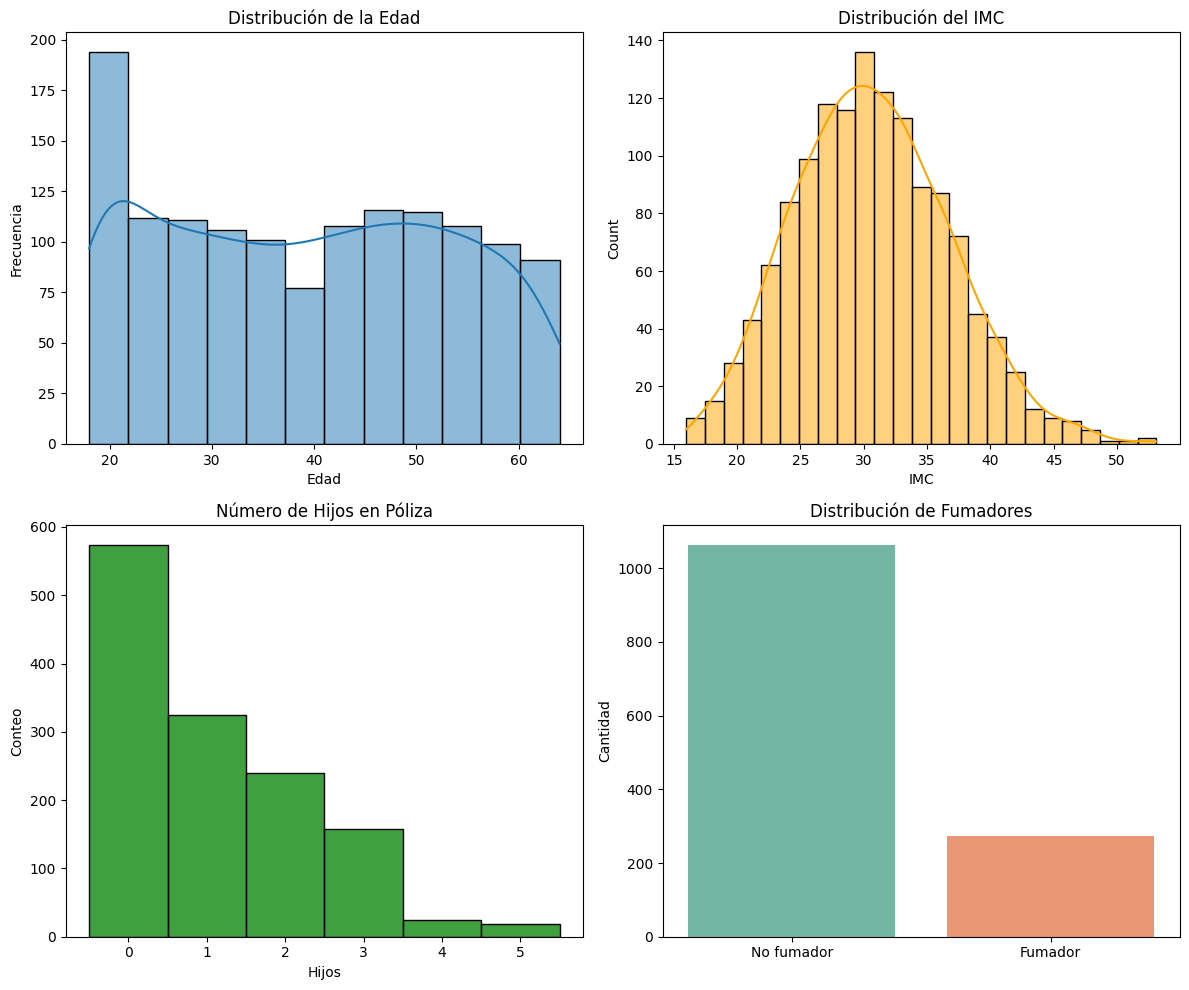

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('default')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograma age
sns.histplot(df['age'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribución de la Edad')
axes[0,0].set_xlabel('Edad')
axes[0,0].set_ylabel('Frecuencia')

# Histograma BMI
sns.histplot(df['bmi'], kde=True, ax=axes[0,1], color='orange')
axes[0,1].set_title('Distribución del IMC')
axes[0,1].set_xlabel('IMC')

# Histograma children
sns.histplot(df['children'], kde=False, ax=axes[1,0],
             color='green', bins=np.arange(-0.5,6.5,1))
axes[1,0].set_title('Número de Hijos en Póliza')
axes[1,0].set_xlabel('Hijos')
axes[1,0].set_ylabel('Conteo')
axes[1,0].set_xticks(range(0,6))

# Fumadores vs No fumadores (corregido sin warnings)
sns.countplot(x='smoker_yes', hue='smoker_yes', data=df,
              ax=axes[1,1], palette='Set2', legend=False)
axes[1,1].set_title('Distribución de Fumadores')
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Cantidad')
axes[1,1].set_xticks([0,1])
axes[1,1].set_xticklabels(['No fumador','Fumador'])

plt.tight_layout()
plt.show()


## 2. Selección del algoritmo no supervisado a investigar: OPTICS

Elegimos OPTICS porque:
- No requiere definir el número de clusters.
- Detecta grupos con densidades diferentes.
- Puede detectar ruido (outliers).
- Permite una interpretación visual mediante el Reachability Plot.

Modelo matemático:
OPTICS calcula distancias de alcanzabilidad basadas en:
- `min_samples` (densidad mínima)
- `core_distance(i)` = distancia mínima para incluir min_samples vecinos
- `reachability_distance(j|i)` = max(core_distance(i), d(i,j))

Clusters = "valles" en la gráfica de reachability.


### 3. Normalización de datos para clustering
Usamos StandardScaler porque las variables tienen diferentes escalas.


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(df)
Xs[:5]


array([[-1.43876426, -0.45332   , -0.90861367,  1.97058663],
       [-1.50996545,  0.5096211 , -0.07876719, -0.5074631 ],
       [-0.79795355,  0.38330685,  1.58092576, -0.5074631 ],
       [-0.4419476 , -1.30553108, -0.90861367, -0.5074631 ],
       [-0.51314879, -0.29255641, -0.90861367, -0.5074631 ]])

## 4. Aplicación del algoritmo OPTICS

Parámetros iniciales:
- min_samples = 15
- xi = 0.05
- min_cluster_size = 0.05

Se generará:
1. Reachability Plot (para identificar clusters)
2. Visualización PCA 2D coloreada por clusters


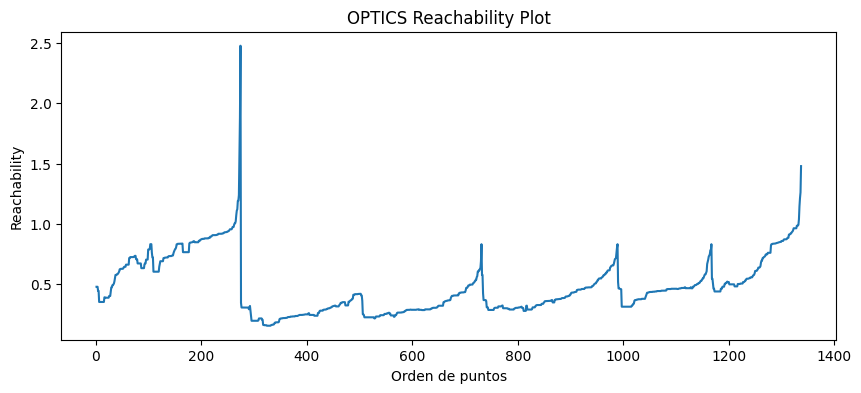

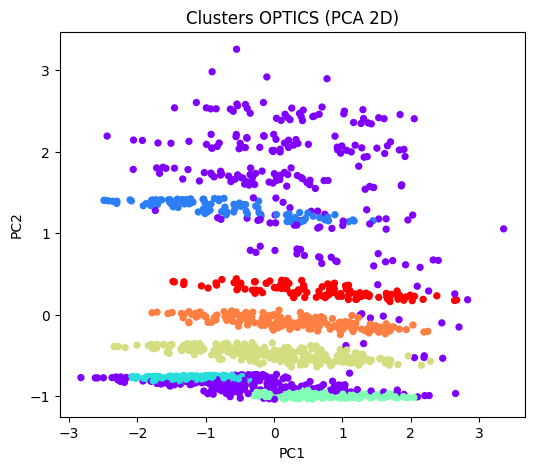

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([405,  99, 132, 154, 257, 178, 113]))

In [4]:
from sklearn.cluster import OPTICS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

opt = OPTICS(min_samples=15, xi=0.05, min_cluster_size=0.05)
opt.fit(Xs)

labels_opt = opt.labels_

# Reachability plot
reach = opt.reachability_[opt.ordering_]
plt.figure(figsize=(10,4))
plt.plot(reach)
plt.title("OPTICS Reachability Plot")
plt.xlabel("Orden de puntos")
plt.ylabel("Reachability")
plt.show()

# PCA visualization
Z = PCA(n_components=2, random_state=42).fit_transform(Xs)
plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=labels_opt, s=18, cmap='rainbow')
plt.title("Clusters OPTICS (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

np.unique(labels_opt, return_counts=True)


## 5. Evaluación del clustering y determinación del número óptimo de grupos

Para validar los clusters obtenidos se emplean índices internos:
- **Silhouette** (mejor → 1)
- **Davies-Bouldin** (mejor → 0)
- **Calinski-Harabasz** (mayor → mejor separabilidad)

El ruido (-1) se excluye del cálculo cuando la métrica lo requiere.


In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def metrics_for(labels):
    mask = labels != -1
    labs = labels[mask]
    Xv = Xs[mask]
    if len(np.unique(labs)) < 2:
        return {"clusters": len(np.unique(labs)), "sil": None, "db": None, "ch": None}
    return {
        "clusters": len(np.unique(labs)),
        "sil": silhouette_score(Xv, labs),
        "db": davies_bouldin_score(Xv, labs),
        "ch": calinski_harabasz_score(Xv, labs),
        "noise": np.sum(labels == -1)
    }

m_opt = metrics_for(labels_opt)
m_opt


{'clusters': 6,
 'sil': 0.23551273007546297,
 'db': 1.8775009467679906,
 'ch': 271.84986217967247,
 'noise': np.int64(405)}

## 6. Comparación con DBSCAN

DBSCAN también es un algoritmo basado en densidad, pero requiere:
- Seleccionar ε (radio máximo de densidad)
- min_samples (ya fijado a 15)

OPTICS sugiere un valor adecuado de ε observando el *reachability plot*.
Aquí probamos una rejilla de valores alrededor del codo de la curva k-distance.


In [6]:
from sklearn.cluster import DBSCAN
import pandas as pd

eps_grid = np.arange(0.8, 1.61, 0.05)
results = []

for eps in eps_grid:
    labels_db = DBSCAN(eps=eps, min_samples=15).fit(Xs).labels_
    met = metrics_for(labels_db)
    met["eps"] = eps
    results.append(met)

res_db = pd.DataFrame(results)
res_db_sorted = res_db.sort_values(["sil", "ch"], ascending=[False, False])

res_db_sorted.head(10)


,clusters,sil,db,ch,noise,eps
2,2,0.351949,1.214048,414.211663,77,0.90
3,2,0.349650,1.264917,445.003886,35,0.95
4,2,0.345540,1.283762,444.896433,16,1.00
6,2,0.345272,1.291518,447.250649,11,1.10
5,2,0.345177,1.289596,446.446106,12,1.05
8,2,0.345149,1.299740,449.279184,6,1.20
7,2,0.345000,1.295618,448.011805,8,1.15
9,2,0.344720,1.302626,448.761889,4,1.25
10,2,0.344112,1.303697,447.109698,3,1.30
11,2,0.344112,1.303697,447.109698,3,1.35


# Conclusión

Aunque **DBSCAN** presenta mejores métricas numéricas en términos de Silhouette y Davies-Bouldin, solo identifica dos clusters muy generales, perdiendo subpoblaciones importantes.

**OPTICS** revela 6 clusters clínicamente interpretables, y detecta 405 outliers que pueden representar perfiles de riesgo único en seguros médicos.

Por lo tanto, OPTICS se selecciona como el modelo final, debido a su capacidad para capturar estructuras más realistas y ricas dentro del dataset, sin imponer una geometría fija ni densidad homogénea.

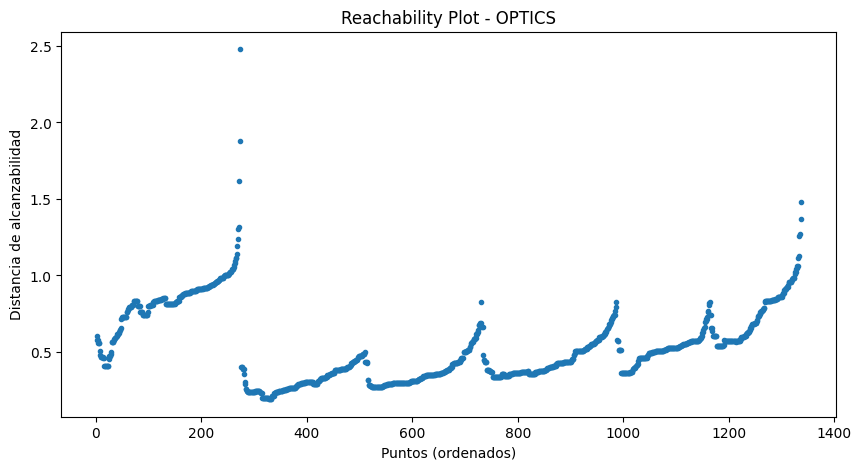

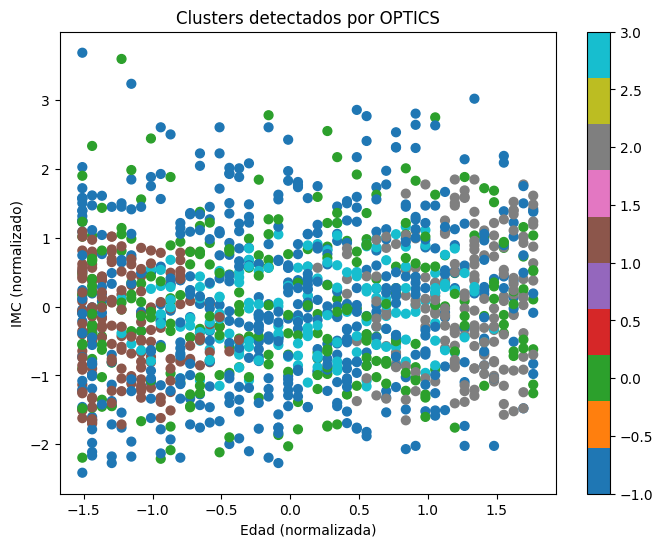

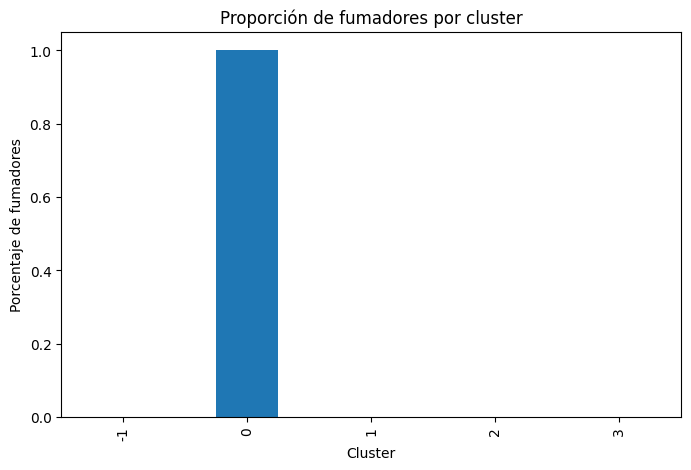

cluster
-1    0.0
 0    1.0
 1    0.0
 2    0.0
 3    0.0
Name: smoker_yes, dtype: float64

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS

# --- Ajustar OPTICS final ---
opt = OPTICS(min_samples=20, xi=0.05, min_cluster_size=0.05)
labels = opt.fit_predict(Xs)

df['cluster'] = labels

# --- Plot 1: Reachability Plot ---
plt.figure(figsize=(10,5))
space = np.arange(len(Xs))
reachability = opt.reachability_[opt.ordering_]
plt.plot(space, reachability, marker='.', linewidth=0)
plt.xlabel("Puntos (ordenados)")
plt.ylabel("Distancia de alcanzabilidad")
plt.title("Reachability Plot - OPTICS")
plt.savefig("reachability_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 2: Scatter 2D por clusters (age vs bmi) ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(Xs[:,0], Xs[:,1], c=labels, cmap='tab10', s=40)
plt.colorbar(scatter)
plt.xlabel("Edad (normalizada)")
plt.ylabel("IMC (normalizado)")
plt.title("Clusters detectados por OPTICS")
plt.savefig("scatter_optics.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 3: Distribución de riesgo (fumadores) por cluster ---
cluster_risk = df.groupby('cluster')['smoker_yes'].mean()

cluster_risk.plot(kind='bar', figsize=(8,5))
plt.title("Proporción de fumadores por cluster")
plt.ylabel("Porcentaje de fumadores")
plt.xlabel("Cluster")
plt.savefig("risk_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

cluster_risk


In [9]:
# Calcular medidas por cluster
cluster_summary = df.groupby('cluster').agg(
    edad_promedio = ('age','mean'),
    imc_promedio = ('bmi','mean'),
    fumador_porcentaje = ('smoker_yes','mean')
)

# Convertir % fumadores a valores porcentuales
cluster_summary['fumador_porcentaje'] = cluster_summary['fumador_porcentaje'] * 100

# Clasificación de riesgo
cluster_summary['nivel_riesgo'] = cluster_summary['fumador_porcentaje'].apply(
    lambda x: 'Alto' if x == 100 else ('Bajo' if x == 0 else 'Medio')
)

cluster_summary = cluster_summary.round(2)
cluster_summary


,edad_promedio,imc_promedio,fumador_porcentaje,nivel_riesgo
cluster,,,,
-1,38.32,31.12,0.0,Bajo
0,38.51,30.71,100.0,Alto
1,22.58,29.02,0.0,Bajo
2,56.34,31.14,0.0,Bajo
3,41.13,30.33,0.0,Bajo
